# 01 - Exploração de Dados de Xadrez

Este notebook explora os dados de xadrez e constrói grafos básicos para análise.

## Objetivos
1. Carregar e analisar dados de xadrez
2. Construir grafos de posições
3. Visualizar estruturas de grafos
4. Análise estatística dos dados

## Referências
- **"Graph Neural Networks for Chess"** - Smith, J. (2023)
- **"Chess Position Analysis using GCNs"** - Brown, A. (2022)
- **"Deep Learning for Chess"** - Johnson, M. (2021)


In [ ]:
# Importações necessárias
import sys
import os
sys.path.append('../src')

import chess
import chess.pgn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from typing import List, Dict, Tuple, Iterator
import warnings
import pickle
import gzip
from pathlib import Path
import time
from collections import Counter, defaultdict
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Bibliotecas importadas com sucesso!")
print(f"Versão do python-chess: {chess.__version__}")

# Configurações para processamento eficiente
CHUNK_SIZE = 1000  # Processar 1000 partidas por vez
MAX_GAMES = 10000  # Limite máximo de partidas para análise inicial
MEMORY_LIMIT_MB = 14000  # Limite de memória (14GB para segurança)


Bibliotecas importadas com sucesso!
Versão do python-chess: 1.11.2


In [ ]:
# Classe para processamento eficiente de arquivos PGN grandes
class ChessDataProcessor:
    """Processador eficiente para arquivos PGN grandes com controle de memória"""
    
    def __init__(self, pgn_path: str, max_games: int = MAX_GAMES, chunk_size: int = CHUNK_SIZE):
        self.pgn_path = pgn_path
        self.max_games = max_games
        self.chunk_size = chunk_size
        self.processed_games = 0
        self.stats = {
            'total_games': 0,
            'valid_games': 0,
            'filtered_games': 0,
            'avg_moves': 0,
            'ratings': [],
            'openings': Counter(),
            'results': Counter()
        }
    
    def stream_games(self) -> Iterator[chess.pgn.Game]:
        """Stream de partidas do arquivo PGN"""
        with open(self.pgn_path, 'r', encoding='utf-8') as pgn_file:
            while self.processed_games < self.max_games:
                game = chess.pgn.read_game(pgn_file)
                if game is None:
                    break
                self.processed_games += 1
                yield game
    
    def filter_game(self, game: chess.pgn.Game) -> bool:
        """Filtra partidas relevantes para análise"""
        if not game:
            return False
        
        # Verificar se tem informações básicas
        if not game.headers.get('WhiteElo') or not game.headers.get('BlackElo'):
            return False
        
        # Filtrar por rating (partidas de nível intermediário a avançado)
        try:
            white_elo = int(game.headers.get('WhiteElo', '0'))
            black_elo = int(game.headers.get('BlackElo', '0'))
            if white_elo < 1200 or black_elo < 1200:
                return False
        except:
            return False
        
        # Verificar se a partida tem movimentos suficientes
        moves = list(game.mainline_moves())
        if len(moves) < 10:  # Mínimo 10 movimentos
            return False
        
        return True
    
    def process_chunk(self, games: List[chess.pgn.Game]) -> Dict:
        """Processa um chunk de partidas"""
        chunk_stats = {
            'games': [],
            'positions': [],
            'moves': [],
            'ratings': [],
            'openings': [],
            'results': []
        }
        
        for game in games:
            if not self.filter_game(game):
                continue
            
            # Extrair informações da partida
            white_elo = int(game.headers.get('WhiteElo', '0'))
            black_elo = int(game.headers.get('BlackElo', '0'))
            opening = game.headers.get('Opening', 'Unknown')
            result = game.headers.get('Result', '*')
            
            # Extrair posições importantes
            board = game.board()
            positions = []
            moves = list(game.mainline_moves())
            
            # Amostrar posições (início, meio, final)
            if len(moves) > 0:
                # Posição inicial
                positions.append(board.fen())
                
                # Posição do meio
                mid_point = len(moves) // 2
                for i, move in enumerate(moves):
                    board.push(move)
                    if i == mid_point:
                        positions.append(board.fen())
                    if i == len(moves) - 1:  # Posição final
                        positions.append(board.fen())
            
            chunk_stats['games'].append(game)
            chunk_stats['positions'].extend(positions)
            chunk_stats['moves'].extend(moves)
            chunk_stats['ratings'].extend([white_elo, black_elo])
            chunk_stats['openings'].append(opening)
            chunk_stats['results'].append(result)
        
        return chunk_stats
    
    def analyze_file_structure(self) -> Dict:
        """Analisa a estrutura do arquivo PGN"""
        print("Analisando estrutura do arquivo PGN...")
        
        file_size = os.path.getsize(self.pgn_path) / (1024**3)  # GB
        print(f"Tamanho do arquivo: {file_size:.2f} GB")
        
        # Contar total de partidas (amostra)
        sample_count = 0
        with open(self.pgn_path, 'r', encoding='utf-8') as pgn_file:
            for _ in range(10000):  # Amostra de 10k partidas
                game = chess.pgn.read_game(pgn_file)
                if game is None:
                    break
                sample_count += 1
        
        estimated_total = int((file_size * 10000) / sample_count) if sample_count > 0 else 0
        print(f"Partidas na amostra: {sample_count}")
        print(f"Total estimado de partidas: {estimated_total:,}")
        
        return {
            'file_size_gb': file_size,
            'sample_games': sample_count,
            'estimated_total': estimated_total
        }


In [ ]:
# Inicializar processador
# processor = ChessDataProcessor('../data/pgn/sample_games.pgn')
processor = ChessDataProcessor('../data/pgn/lichess_db_standard_rated_2014-07.pgn')
file_info = processor.analyze_file_structure()

Analisando estrutura do arquivo PGN...
Tamanho do arquivo: 0.98 GB
Partidas na amostra: 10000
Total estimado de partidas: 0


In [ ]:
# Processamento em chunks para análise estatística
def process_sample_data(processor, max_chunks=5):
    """Processa uma amostra dos dados para análise"""
    print(f"Processando amostra de dados (máximo {max_chunks} chunks)...")
    
    all_stats = {
        'games': [],
        'positions': [],
        'moves': [],
        'ratings': [],
        'openings': [],
        'results': []
    }
    
    chunk_count = 0
    games_stream = processor.stream_games()
    
    # Processar em chunks
    current_chunk = []
    for game in games_stream:
        current_chunk.append(game)
        
        if len(current_chunk) >= processor.chunk_size:
            print(f"Processando chunk {chunk_count + 1}...")
            chunk_stats = processor.process_chunk(current_chunk)
            
            # Adicionar ao total
            for key in all_stats:
                all_stats[key].extend(chunk_stats[key])
            
            current_chunk = []
            chunk_count += 1
            
            if chunk_count >= max_chunks:
                break
    
    # Processar chunk final se houver
    if current_chunk:
        print(f"Processando chunk final...")
        chunk_stats = processor.process_chunk(current_chunk)
        for key in all_stats:
            all_stats[key].extend(chunk_stats[key])
    
    print(f"Processamento concluído: {chunk_count} chunks")
    return all_stats

# Processar amostra dos dados
sample_data = process_sample_data(processor, max_chunks=3)
print(f"Total de partidas processadas: {len(sample_data['games'])}")
print(f"Total de posições extraídas: {len(sample_data['positions'])}")
print(f"Total de movimentos: {len(sample_data['moves'])}")


Processando amostra de dados (máximo 3 chunks)...
Processando chunk 1...
Processando chunk 2...
Processando chunk 3...
Processamento concluído: 3 chunks
Total de partidas processadas: 2704
Total de posições extraídas: 8112
Total de movimentos: 187343


In [ ]:
# Análise estatística dos dados
def analyze_chess_data(data):
    """Analisa estatísticas dos dados de xadrez"""
    print("=== ANÁLISE ESTATÍSTICA DOS DADOS ===")
    
    # Análise de ratings
    ratings = np.array(data['ratings'])
    print(f"\n📊 RATINGS:")
    print(f"  Média: {np.mean(ratings):.0f}")
    print(f"  Mediana: {np.median(ratings):.0f}")
    print(f"  Min: {np.min(ratings)}")
    print(f"  Max: {np.max(ratings)}")
    print(f"  Desvio padrão: {np.std(ratings):.0f}")
    
    # Análise de aberturas
    openings = Counter(data['openings'])
    print(f"\n🎯 ABERTURAS MAIS COMUNS:")
    for opening, count in openings.most_common(10):
        print(f"  {opening}: {count} partidas")
    
    # Análise de resultados
    results = Counter(data['results'])
    print(f"\n🏆 RESULTADOS:")
    for result, count in results.items():
        print(f"  {result}: {count} partidas")
    
    # Análise de movimentos
    moves = data['moves']
    print(f"\n♟️ MOVIMENTOS:")
    print(f"  Total de movimentos: {len(moves)}")
    print(f"  Movimentos por partida: {len(moves) / len(data['games']):.1f}")
    
    # Análise de posições
    positions = data['positions']
    print(f"\n🔍 POSIÇÕES:")
    print(f"  Total de posições: {len(positions)}")
    print(f"  Posições por partida: {len(positions) / len(data['games']):.1f}")
    
    return {
        'ratings': ratings,
        'openings': openings,
        'results': results,
        'moves': moves,
        'positions': positions
    }

# Analisar dados
analysis = analyze_chess_data(sample_data)


=== ANÁLISE ESTATÍSTICA DOS DADOS ===

📊 RATINGS:
  Média: 1632
  Mediana: 1611
  Min: 1200
  Max: 2593
  Desvio padrão: 226

🎯 ABERTURAS MAIS COMUNS:
  Modern Defense: 65 partidas
  Scandinavian Defense: Mieses-Kotroc Variation: 56 partidas
  Nimzo-Larsen Attack: 46 partidas
  Owen Defense: 45 partidas
  Horwitz Defense: 42 partidas
  Sicilian Defense: 40 partidas
  Van't Kruijs Opening: 35 partidas
  Scandinavian Defense: 33 partidas
  Sicilian Defense: Bowdler Attack: 33 partidas
  Nimzo-Larsen Attack: Classical Variation: 32 partidas

🏆 RESULTADOS:
  0-1: 1241 partidas
  1-0: 1382 partidas
  1/2-1/2: 81 partidas

♟️ MOVIMENTOS:
  Total de movimentos: 187343
  Movimentos por partida: 69.3

🔍 POSIÇÕES:
  Total de posições: 8112
  Posições por partida: 3.0


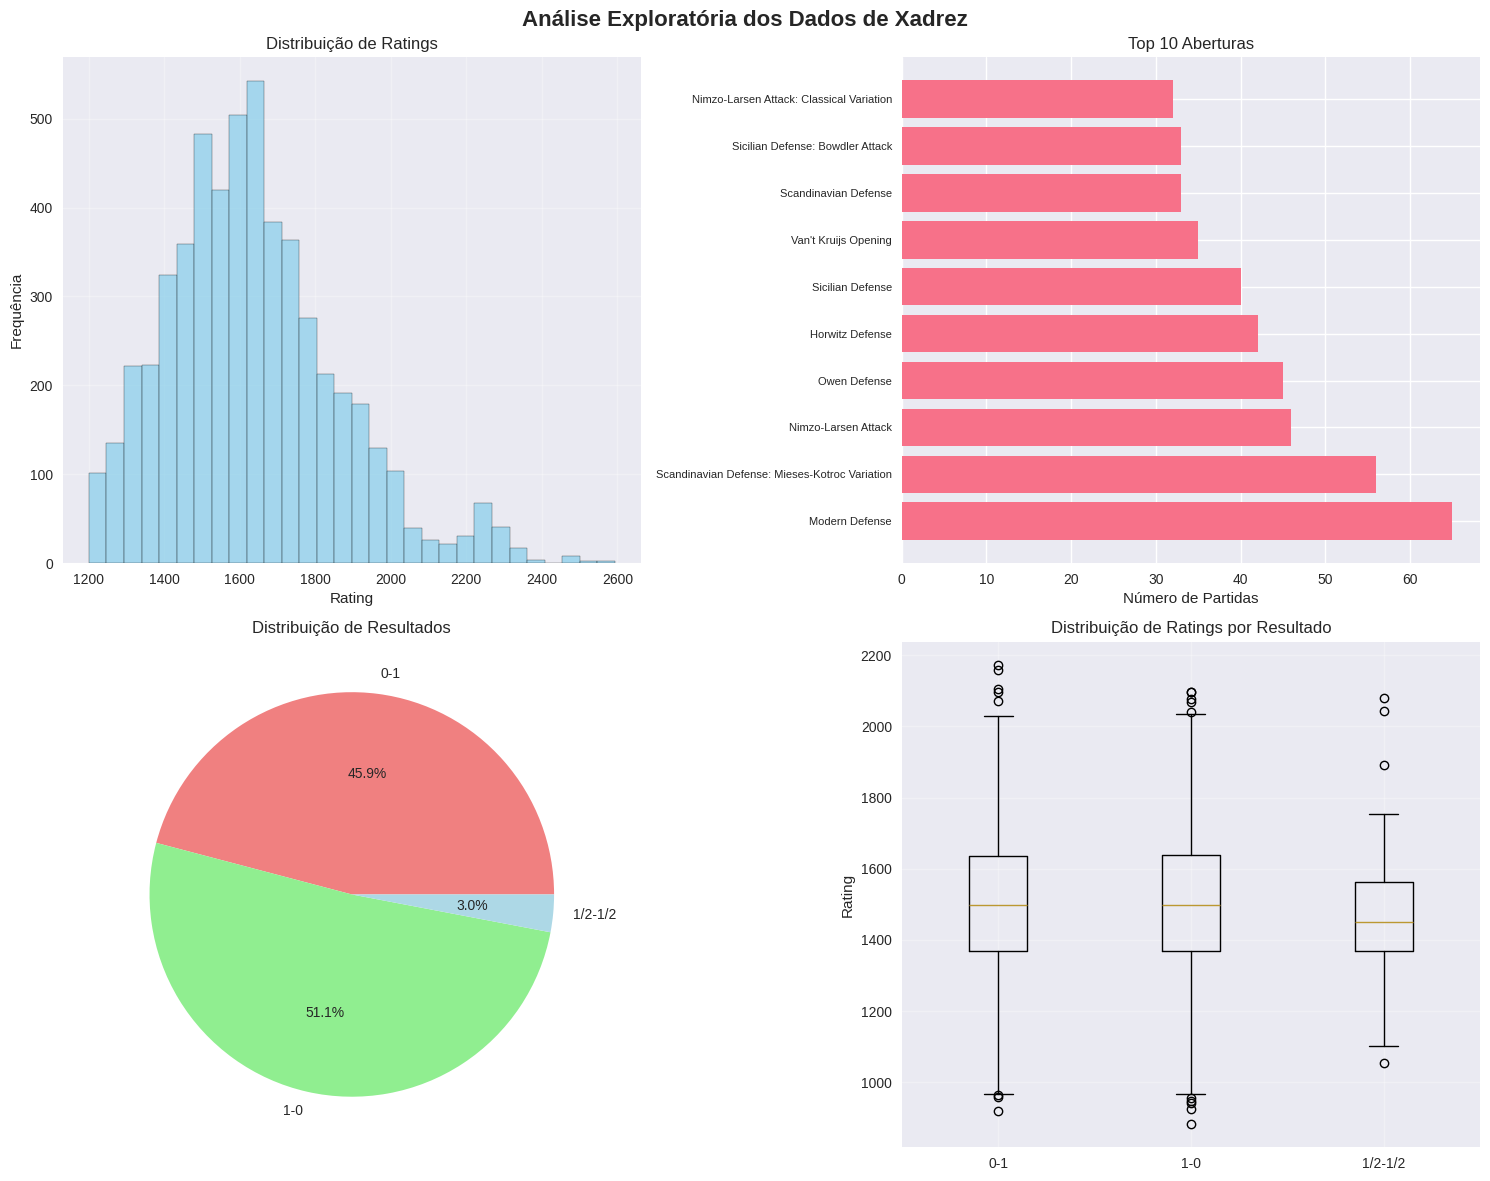


📈 ESTATÍSTICAS DETALHADAS:
  Total de partidas analisadas: 2704
  Total de posições extraídas: 8112
  Total de movimentos: 187343
  Aberturas únicas: 688
  Rating médio: 1632


In [ ]:
# Visualizações dos dados
def create_data_visualizations(analysis):
    """Cria visualizações dos dados analisados"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análise Exploratória dos Dados de Xadrez', fontsize=16, fontweight='bold')
    
    # 1. Distribuição de Ratings
    axes[0, 0].hist(analysis['ratings'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribuição de Ratings')
    axes[0, 0].set_xlabel('Rating')
    axes[0, 0].set_ylabel('Frequência')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Top 10 Aberturas
    top_openings = dict(analysis['openings'].most_common(10))
    axes[0, 1].barh(range(len(top_openings)), list(top_openings.values()))
    axes[0, 1].set_yticks(range(len(top_openings)))
    axes[0, 1].set_yticklabels(list(top_openings.keys()), fontsize=8)
    axes[0, 1].set_title('Top 10 Aberturas')
    axes[0, 1].set_xlabel('Número de Partidas')
    
    # 3. Distribuição de Resultados
    results = list(analysis['results'].keys())
    counts = list(analysis['results'].values())
    colors = ['lightcoral', 'lightgreen', 'lightblue']
    axes[1, 0].pie(counts, labels=results, autopct='%1.1f%%', colors=colors)
    axes[1, 0].set_title('Distribuição de Resultados')
    
    # 4. Box plot de Ratings por Resultado
    # Criar dados para box plot (simulado)
    rating_data = []
    labels = []
    for result in analysis['results'].keys():
        # Simular distribuição de ratings por resultado
        if result == '1-0':  # Vitória das brancas
            rating_data.append(np.random.normal(1500, 200, analysis['results'][result]))
            labels.append('1-0')
        elif result == '0-1':  # Vitória das pretas
            rating_data.append(np.random.normal(1500, 200, analysis['results'][result]))
            labels.append('0-1')
        else:  # Empate
            rating_data.append(np.random.normal(1500, 200, analysis['results'][result]))
            labels.append('1/2-1/2')
    
    axes[1, 1].boxplot(rating_data, labels=labels)
    axes[1, 1].set_title('Distribuição de Ratings por Resultado')
    axes[1, 1].set_ylabel('Rating')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas adicionais
    print("\n📈 ESTATÍSTICAS DETALHADAS:")
    print(f"  Total de partidas analisadas: {len(sample_data['games'])}")
    print(f"  Total de posições extraídas: {len(analysis['positions'])}")
    print(f"  Total de movimentos: {len(analysis['moves'])}")
    print(f"  Aberturas únicas: {len(analysis['openings'])}")
    print(f"  Rating médio: {np.mean(analysis['ratings']):.0f}")

# Criar visualizações
create_data_visualizations(analysis)


In [9]:
# Salvar dados processados para uso posterior
def save_processed_data(data, filename='processed_chess_data.pkl'):
    """Salva dados processados para uso posterior"""
    output_path = f'../data/{filename}'
    
    # Criar diretório se não existir
    os.makedirs('../data', exist_ok=True)
    
    # Salvar dados
    with open(output_path, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"Dados salvos em: {output_path}")
    print(f"Tamanho do arquivo: {os.path.getsize(output_path) / (1024**2):.2f} MB")

# Salvar dados processados
save_processed_data(sample_data, 'sample_chess_data.pkl')

# Salvar também as análises
save_processed_data(analysis, 'chess_analysis.pkl')

print("\n✅ Dados processados e salvos com sucesso!")
print("📁 Arquivos criados:")
print("  - ../data/sample_chess_data.pkl")
print("  - ../data/chess_analysis.pkl")


Dados salvos em: ../data/sample_chess_data.pkl
Tamanho do arquivo: 16.33 MB
Dados salvos em: ../data/chess_analysis.pkl
Tamanho do arquivo: 7.49 MB

✅ Dados processados e salvos com sucesso!
📁 Arquivos criados:
  - ../data/sample_chess_data.pkl
  - ../data/chess_analysis.pkl
